<h1 style="text-align: center; font-size: 24pt; color : #f31567; font-family: Comic Sans MS;">
    Analytic Model for Estimation of Light Yield version 2.0 
<!-- <span style= 'color : #f31567'> Analytic Model for Light Yield Estimation version 2.0 </span>  -->
<!-- <span style= 'color : #f31567'> Analytic Model for Estimating Light Collection Efficiency Version 2.0 </span>  -->
</h1>
<br>
<br>

<div style="width:1050px;height:60px;border:1px solid red; background-color: black;"> 
<p style='color: white;font-size:18pt;'> <b>
<!-- important: <span style='color: white;'> As of 12 Dec 2021, this notebook has latest changes. </span> </b> -->
Note: <span style='color: white;'> This version of notebook was implement for DWArF calculations. </span> </b>
</p>
</div>

<p style='color : #9932CC;  font-size: 16pt; font-family: Comic Sans MS;'>
    Story so far.. :
<span style= 'color : silver; text-align: center;font-family: Comic Sans MS;'> This notebook is written to implement Segreto model.
    <ol style = 'font-family: consolas;'>
       <li> It has the provision to include the Rayleigh scattering and absorption. ✅</li> 
       <li> renamed few variables to be compliant with Segreto's paper. ✅</li>
       <li> I will add additional terms later for the configuration where even SiPM is covered with WLS. ✅</li>
        <li> we have a serious problem when f_sen =1, LY =0 which shouldn't be the case. ✅</li>
        <li> Are regular SiPM's sensitive to VUV?
            <span style ='color: green;'> short answer: NO! </span>
        <li> check out why Segreto has a weird way of extrapolating his model when number of SiPM > 1 </li>
        <li> what is WLS's reflectance to VUV</li>
        <li> We are not accounting for absorption of Visible light in WLS coated over SiPM, obviously without ESR its reflectance will drop and it will allow visible photon to pass more freely but absorption and reflectance could still be significant. To fix this we should use reflectance values of WLS coupled with SiPM.<span style = 'color: orange;'> Ask Marcin. </span></li>
        <li> Confirm TPC and Titanium Vessel dimensions ✅
        <li> Verified V1 and V2 are consistent with eacher other when SiPM's are not covered. ✅</li>
    </ol>

</span> 
<p style = 'color: skyblue;'> Important notes:
<ul>
       <li> default value Q_vis = 1</li>
        <li> default value Q_vuv = 1</li>
        <li> default value $\epsilon_{wls} = 1 $</li>
        <li> default value SY=40</li>
        <li> throughout this notebook the unit of length is m</li>
</ul>
</p>

<h2 style = 'text-align: center; font-size: 24pt; color: #66AAEE;'> Setting up the notebook</h2>

In [1]:
%%html
<!--- html styling for Jupyter Dark Theme---!>
<style>
.CodeMirror-focused .CodeMirror-selected { background: none; }
.CodeMirror-focused .CodeMirror-selectedtext { color: black !important; background: #50F148; } 
.CodeMirror-selected { background:  grey; }
</style>
<!--- greenish #00FF88 ; pinkish #FF0088 ; turquoise---!>

In [2]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return False;
# }

In [3]:
from os import path
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sympy import Symbol, exp, integrate

from matplotlib import lines
from matplotlib import cm
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
# %matplotlib inline
# %matplotlib qt

In [4]:
# Change rc parameters for all matplotlib plots
# rc('figure', autolayout=True, dpi=125)
# rc('figure', autolayout=True, figsize=[16, 9], dpi=125)
rc('figure', autolayout=True, figsize=[16, 9], dpi=75)
rc('font', family='monospace')
rc('axes', titlesize=20, titleweight='heavy', labelsize=18, labelweight='bold')
rc(('xtick', 'ytick'), labelsize = 16)
rc('legend', fontsize=14)

<h1 style = 'color: #ff0038; text-align: center'> Light Yield Analytic Model</h1>

<p style = 'color: grey;'> Formulation for simple Analytic Model without wavelength shifter and Absorption/scattering effects: </p>

<span style = 'color: back; font-size:14pt;'>    
$$
LCE = \frac{X}{1-(s+w)} 
$$
<br>
$$ 
LCE = \frac{f_{sen}FF_{sys}(1-R)}{1-( f_{sen}R + (1-f_{sen})R_{wall} )}
$$
<br>
</span>

<p style = 'color:tomato; text-align: left; font-family: Comic Sans MS;'> 
    Overleaf Document: 
<a href="https://www.overleaf.com/read/vpkvkgpfqwst">https://www.overleaf.com/read/vpkvkgpfqwst</a>
<br>
    Research Notes: 
<a href="https://docs.google.com/document/d/1k-8OMUld0fGFGO-Om6wp_pJkQwOL-QxgrfYoKsZIPF4/edit">Google Docs link </a>
<br>
    Other Relevant Documentations: 
<a href="https://arxiv.org/pdf/1110.6370.pdf">Segreto 2012</a>    
</p>
<hr>

<h2 style = 'color:#66AAEE;'>    Data loading & Pre-processing </h2>

<p style ='color: black; font-size: 14pt'> project directory is defined in the following cell; it will remain same through out the notebook.
</p>
<p style ='color: black; font-size: 14pt'>PS:  The preprocessing is different for each file depending on its data structure.
</p>

<h3 style = 'color: #7bc5ef; '> ✏ Project Directory </h3>

In [5]:
### define project directory
project_dir = '..'

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> SiPM Reflectance data </h3>
<!-- <p>
    SiPM Reflectance .dat file provided by Cenk
    <br>
    <span style = 'color: #FF6611; font-size: 18px'> Note: </span> 
    SiPM Reflectance is multiplied by 0.91 to take care of the effect of antireflective coating in Liquid Argon chamber (needs further investigtation)
</p> -->

In [6]:
R_SiPM_df = pd.read_csv(path.join(project_dir, 'data','sipm_hr1_processed.txt'), sep = '\t')  ## 'Data' is the name of the folder containing Data files
R_SiPM = R_SiPM_df.copy()
R_SiPM['R'] = [int(value)/100 for value in R_SiPM_df['R']]

## cenk's data files for darkside veto are given below

# cenk_SiPM_R_df = pd.read_csv(path.join(project_dir, 'Data','SiPM_ref.csv'), sep = ',')
# # cenk_SiPM_R_values = cenk_SiPM_R_vector.copy()
# # cenk_R_SiPM_values['R'] = [int(value)/100 for value in cenk_R_SiPM_vector['R']]
# cenk_SiPM_R_df2 = cenk_SiPM_R_df.copy()
# cenk_SiPM_R_df2['LAr_equivalent_Reflectance'] = cenk_SiPM_R_df2['R']*0.91 

# ### Note: SiPM is coated with an unknown anti-reflection coating
# ### 0.91 : To get the unknown reflectivity of SiPM in Liquid Argon. Since SiPM is also coated with an anti reflection coating, getting the equivalent 
# ### reflectance is not straight forward. 0.91 is based on an educated guess.

# cenk_SiPM_R_df2['wavelength'] = 1239.847/cenk_SiPM_R_df2['E'] # Eneergy unit eV wavlength Unit: nm
# # SiPM_ref.dat
# # cenk_SiPM_R_df3 = cenk_SiPM_R_df2.sort_values(by = 'wavelength')

FileNotFoundError: [Errno 2] No such file or directory: './data/sipm_hr1_processed.txt'

In [ ]:
# cenk_SiPM_R_df2.head()

In [ ]:
# plt.figure()
# plt.plot(cenk_SiPM_R_df2['wavelength'], cenk_SiPM_R_df2['R'])
# plt.plot(SiPM_R_values['Wavelength'], SiPM_R_values['R'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>     SiPM PDE data</h3>
<p>
    Caustion : when using FBK PDE values, normalize with 40/52.77
    <br>
    Marcin: normalize LFoundry values as well. After normalizaton maximum value should be  40.
</p>

In [ ]:
### FBK Values sent by cenk
# photon_wavelength = [285.87, 301.14, 320.99, 340.83, 365.26, 380.53, 391.22, 400.38, 411.06, 420.22, 435.49, 449.23, 464.50, 499.61, 588.16, 698.09]
# PDE_vector = [18.39, 37.24, 41.87, 42.43, 45.03, 48.12, 52.72, 52.75, 52.77, 52.29, 48.77, 46.26, 40.71, 38.76, 28.82, 18.93] # %age values
# PDE_normalized_vector = []
### Normalizing PDE values in FBK data as instructed by Cenk
# PDE_normalized_vector = [value*40/max(PDE_vector) for value in PDE_vector]
## PDE_normalized_vector
# norm_PDE_values = [value/100 for value in PDE_normalized_vector]

### LFoundry PDE Values sent by Cenk
photon_wavelength = [365.39, 390.34, 399.89, 409.98, 420.06, 434.93, 450.32, 500.21, 525.16, 545.33, 590.98, 630.25, 700.32]
PDE_vector = [43.277, 51.892, 54.257, 52.399, 50.709, 46.993, 42.601, 36.014, 30.439, 28.581, 24.358, 20.473, 15.574]
# Normalization for PDE values 
norm_PDE_values = [value*40/(100* max(PDE_vector)) for value in PDE_vector]


frame = {'photon_wavelength':photon_wavelength, 'PDE_norm': norm_PDE_values}

PDE = pd.DataFrame(frame)

# max(PDE['PDE_norm'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>   PEN Reflectance Data </h3>
<!-- <p>
<span style= 'color: red; font-size : 22px'>  Needs verification !!! 
</span>
</p> -->

In [ ]:
## R_wall_PEN = 
PEN_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,
2.884,2.918,2.952,2.988,3.024,3.039,3.047,3.054,3.062,3.069,3.077,3.085,3.092,3.100,3.108,3.116,3.123,3.131,3.139,3.147,3.155,
3.163,3.171,3.179,3.188,3.196,3.204,3.212,3.221,3.263, 8.0] ## energy in eV

PEN_reflectance = [100.130, 100.130,99.995,99.856,99.681,99.659,99.569,99.351,99.306,99.018,98.652,98.415,98.283,
98.018,97.856,97.606,97.457,97.134,96.928,96.827,96.247,95.737,95.359,95.197,95.048,94.876,94.684,94.463,94.055,93.650,93.147,
92.562,91.812,90.904,89.807,88.506,86.957,85.242,83.156,80.678,77.811,74.615,71.004,67.089,62.924,58.670,20.000, 20.000] ## %age reflectance

# PEN_reflectance = [reflectance*0.98/100 for reflectance in PEN_reflectance] 
PEN_reflectance = [reflectance*0.98*0.994/100 for reflectance in PEN_reflectance] 

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance


photon_wavelength = []

for energy_value in PEN_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'PEN_reflectance': PEN_reflectance}

R_Wall_PEN = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_PEN = R_Wall_PEN.iloc[::-1]

# R_Wall_PEN

In [ ]:
## temp
# plt.figure()
# # R_Wall_PEN
# plt.scatter(R_Wall_PEN['photon_wavelength'].iloc[:-1], R_Wall_PEN['PEN_reflectance'].iloc[:-1])
# R_Wall_PEN['photon_wavelength'].iloc[:-1]

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> PEN Emission Spectrum </h3>

In [ ]:
# r_PEN = r'D:\D Downloads\Current_work\pen-tess.txt'
r_PEN = path.join(project_dir, 'data', 'pen-tess.txt')
emission_spectrum_PEN = pd.read_csv(r_PEN, sep ='\t')

E_PEN = emission_spectrum_PEN.drop(['a','b','c'], axis=1)

# E_PEN

# normalize : divide by maximum value
E_PEN['efficiency'] = E_PEN['efficiency']/max(E_PEN['efficiency'] ) 

# remove negative values
E_PEN = E_PEN[E_PEN > 0].dropna()
# E_PEN['efficiency']
## What are the units of efficiency? Normalize PEN Spectrum ??
## Remove negative values?
## Need linear interpolation for everyuthing R, R_Wall, PDE and emission spectrum
# plt.plot(E_PEN['wavelength'], E_PEN['efficiency']) ## temp

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> TPB Reflectance data </h3>

In [ ]:
TPB_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,2.884,2.918,2.952,2.988,3.024, 3.221,3.263, 8.0]
TPB_reflectance = [98.936,98.936,99.180,99.309,99.375,99.392,99.534,99.490,99.491,99.685,99.635,99.593,99.541,99.457,99.380,99.374,99.196,98.924,98.521,97.653,95.581,92.569,13.0,3.0,3.0]

photon_wavelength = []

# TPB_reflectance = [reflectance*0.98/100 for reflectance in TPB_reflectance]
TPB_reflectance = [reflectance*0.98*0.994/100 for reflectance in TPB_reflectance]

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance

for energy_value in TPB_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'TPB_reflectance': TPB_reflectance}

R_Wall_TPB = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_TPB = R_Wall_TPB.iloc[::-1]

# R_Wall_TPB

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt'> TPB Emission Spectrum </h3>

In [ ]:
#### why do we have negative values?
#### Might need to clean data
## drop negative values
## normalize efficiency

# r_TPB = r'D:\D Downloads\Current_work\tpb-fran.txt'
r_TPB = path.join(project_dir, 'data','tpb-fran.txt')
emission_spectrum_TPB = pd.read_csv(r_TPB, sep ='\t')

E_TPB = emission_spectrum_TPB.drop(['a','b','c','d'], axis=1)
# E_TPB

<p style = 'color:slate'> Click here to see a warning </p>
<!-- Warning: TPB data has negative values -->

In [ ]:
# normalize : divide by maximum value
E_TPB['efficiency'] = E_TPB['efficiency']/max(E_TPB['efficiency'] ) 
# remove negative values
E_TPB = E_TPB[E_TPB > 0].dropna()

# E_TPB


<h3 style = 'color:deeppink'> Smoothing function </h3>

In [ ]:
### variable name 'photon_wavelength' is NOT hard coded for all the data frames.
def make_smooth(data_frame_var):
    name_column_0 = data_frame_var.columns[0]
    name_column_1 = data_frame_var.columns[1]
    
    photon_wavelength = data_frame_var[name_column_0]
    physical_quantity = data_frame_var[name_column_1]
    
    interpol_func = interp1d(photon_wavelength , physical_quantity)
    return  interpol_func(wavelength_vector)

<h3 style = "font-size:18pt; font-family: courier prime; color: #7bc5ef; weight: bold"> ✏ Define Wavelength range </h3>
<br>
<p style = 'color:silver'>
    wavelength_vector is common throughout the notebook.
</p>

In [ ]:
wavelength_vector = np.arange(366, 560, 0.5)  ### do we want to hard code wavelength range?

In [ ]:
### call smoothing functions here
R_SiPM_smooth = make_smooth(R_SiPM)

R_Wall_PEN_smooth = make_smooth(R_Wall_PEN)

R_Wall_TPB_smooth = make_smooth(R_Wall_TPB)

PDE_smooth = make_smooth(PDE)

E_PEN_smooth = make_smooth(E_PEN)

E_TPB_smooth = make_smooth(E_TPB)   

<h2 style= 'color: #66AAEE'> Wavelength integrated LY with Absorbtion and Rayleigh Scattering effect </h2>

<br>
<p style = 'color: green; text-align: center;'>
    <span style = 'color : black;  font-size:14pt;'> 
    $ X = f_{sen} \times FF_{sys} \times (1-R)$
        <br>
        <br>
        $ s = f_{sen} \times R $
        <br>
        <br>
        $ w = (1-f_{sen}) \times R_{wall} $
        <br>
        <br>
    </span>
    <span>
    If $U_{RA}$ is the probability of interaction either absorption or Rayleigh scattering before photon completes one step, we define new X, s and w parameters to account for Absorption and Rayleigh Scattering:
    </span>
    <span style = 'color : black;  font-size:14pt;'> 
        <br>
        <br>
        $ X_{RA} = U_{RA} \times X$
        <br>
        <br>
        $ (s_{RA} + w_{RA}) = U_{RA} \times (s + w) + (1 - U_{RA}) \times \frac{\lambda_{eff}}{\lambda_R} $
        <br>
        <br>
        $ LCE = \frac{X_{RA}}{1 - (s_{RA} + w_{RA})}   $
        <br>
        <br>
    </span>
on substituting and rearranging terms: 
    <span style = 'color: black; font-size:14pt;'>
    <br>
    <br>
        $ LCE = \frac{X}{Q-(s+w)} $
    </span>
<br>
<br>
    where
<br>
<br>
<span style ='color:black; font-size:14pt;' >
$
U_{RA} = \int_0 ^\infty P(x) \, e^{-\frac{x}{\lambda_{eff}}}\,dx
$
<br>
<br>
$$
    \frac{1}{\lambda_{eff}} = \frac{1}{\lambda_{abs}} + \frac{1}{\lambda_{R}}
$$

<br>
<br>
$P(x) = \frac{1}{L_{char}}$
<br>    
<br>
$$ L_{char} = 6\times \frac{volume}{surface\_area}
$$
<br>
<br>
$
Q = \frac{1- (1 - U_{RA}) \times \frac{\lambda_{eff}}{\lambda_{R}}}{U_{RA}}
$
<br>
<br>
</span>
</p>

<h3 style = 'color: DeepPink '> calculating $Q$ factor </h3>

In [ ]:
# from sympy import Symbol, exp, integrate

x = Symbol('x')

## L_char is basically what L tilde is in segreto paper

## lambda_eff is basically lambda tilde in segreto paper

def calc_lambda_eff(lambda_abs, lambda_R):
    ''' Calculates effective lambda for Rayleigh scattering and Absorption.
    Unit of length: m
    '''
    return (lambda_R*lambda_abs)/(lambda_R + lambda_abs)

def P_func(L_char, lambda_eff):
    '''
    P_func: P(x) is the probability distribution of the distances that a photon would travel in absence of interactions (between two reflections or between a reflection and absorption/detection).
    The P_func can be changed later if it is felt that we need a different probability distribution function. 
    '''
    return 1/(L_char)

def calc_URA(L_char, lambda_eff, Prob_distr):
    return integrate( Prob_distr*exp(-x/lambda_eff), (x, 0, L_char))

def calc_Q( L_char,  lambda_abs, lambda_R):
    ''' 
    This function is used to compute Q factor for both visible and VUV photons.
    Note:
    We'll call calc_URA since URA is wavelength dependent. We'll also make a call to P_func for the same reason.
    '''
    lambda_eff = calc_lambda_eff(lambda_abs, lambda_R)
    
    Pdf = P_func(L_char, lambda_eff); # Probability distribution function
    
    URA_value = float(calc_URA(L_char, lambda_eff, Pdf));
    
    return (1-(1-URA_value)*lambda_eff/lambda_R)/(URA_value)

<h3 style = 'color:deeppink;'> Calculating characteristic length </h3>
<p style = 'color:black; font-size:14pt'>
$$ L_{char} = 6\times \frac{volume}{surface\_area}
$$
</p>

In [ ]:
def calc_char_length(area, volume):
    return 6*volume/area

<h3 style = 'color:DeepPink;'>  Calculating $F $ </h3>
<span style = 'color : black;  font-size:14pt;'>

$$ 
F( Q, f_{sen}FF_{sys}(1-R), f_{sen}R + (1-f_{sen} )R_{wall} ) = \frac{f_{sen}FF_{sys}(1-\color{Red}R)}{\color{Red}Q-( f_{sen}\color{Red}R + (1-f_{sen})\color{Red}{R_{wall}} )}
$$
</span>
<span style = 'color : black;  font-size:14pt;'>

$$ F(Q,X, s + w) = \frac{X}{Q-(s+w)} $$

</span>
<br>

In [ ]:
def calc_F(R, R_wall, f_sen, FF_sys, Q_value):    
    '''
    R, R_wall are all wavelength dependent. Q_value is provided as an argument.
    ''' 
    return (f_sen*FF_sys*(1-R))/(Q_value - (f_sen*R + (1-f_sen)*R_wall) )

<h3 style = 'color: DeepPink '> Calculating Light Collection Efficiency, $LCE$ </h3>

<br>
<span style = 'color:green; font-size: 14pt'> When SiPM's are not covered with WLS. </span>
<span style = 'color:black;  font-size:14pt;'> 
    $$
    LCE = \frac{(1-f_{sen}) \times \epsilon_{wls} \times \color{Red}{F(Q_{vis}, X, s+w)}}{Q_{VUV}}
    $$
</span>
<br>

<br>
<p style = 'color:green; font-size: 14pt'> When SiPM's are covered with WLS.
    <br>
    <span style = 'color:skyblue;'> Note: R_SiPM will be the reflectance of WLS coupled with SiPM.
    <br>
    Stack : WLS | SiPM  </span>
</p>
<br>

<span style = 'color:black;  font-size:14pt;'> 
    $$
    LCE = \frac{(1-R) \times f_{sen} \times \epsilon_{wls} }{ 2 \times Q_{VUV}}  +  \left( \frac{f_{sen} \times \epsilon_{wls}}{ 2\times Q_{VUV}}  + \frac{ (1- f_{sen}) \times \epsilon_{wls} } {Q_{VUV}} \right) \times \color{Red}{F(Q_{vis}, X, s+w)} 
    $$

</span>
<br>

In [ ]:
def calc_LCE(R, R_wall, f_sen, FF_sys, wls_eff, Q_vuv=1, Q_vis=1, SiPM_covered = False):
    ''' calc_LCE requires Q_vis and Q_vuv values as arguments. Both are set at default value of 1.
    Though Absorption and Rayleigh scattering lengths will be dependent on wavelength,
    currently we don't have accurate meansurements of these values for different wavelengths.
    Hence we will be using an average value for entire visible spectrum and another value for VUV (remember VUV photon has a single wavelength).
    In case accurate values of absorption and scattering lengths become available I will need to modify the Q_vis accordingly.
    Side note: Q_vis and Q_vuv are provided as arguments to the function integrate_LY.
    New!!! calc_LCE has additional Arguement SiPM_covered. 
    Note by default LCE is calculated for the case when SiPM is not covered with WLS.
    '''
    # if SiPM_covered == False:
    #     return (1-f_sen)*wls_eff*calc_F(R, R_wall, f_sen, FF_sys, Q_vis)/(Q_vuv)
    # elif SiPM_covered == True:
    #     return (wls_eff/Q_vuv)*( (1-R)*f_sen/2 + (1-0.5*f_sen)*calc_F(R, R_wall, f_sen, FF_sys, Q_vis) )
    if SiPM_covered:
        return (wls_eff/Q_vuv)*( (1-R)*f_sen/2 + (1-0.5*f_sen)*calc_F(R, R_wall, f_sen, FF_sys, Q_vis) )
    else:
        return (1-f_sen)*wls_eff*calc_F(R, R_wall, f_sen, FF_sys, Q_vis)/(Q_vuv)

<h3 style = 'color: DeepPink; text-align:center; font-size:24pt; '> 🍕 integrate Light Yield </h3>

<!-- <p>
Previously known as Weighted Average of Light Yield 
</p> -->

<!-- <p> 
<span style = 'color : #5EA9E5;'> 
<br>
% $$
% integrate\_LY = \frac{\sum( [LY\_value(\color{red}{PDE(\lambda)}, f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls} ) ] * \color{red}{E_{wls}(\lambda)})}{\sum \color{red}{E_{wls}(\lambda)}}
% $$
</span>
<br>
<br>
<br>
</p> -->

<span style = 'color : black; font-size:14pt;'> 
<br>
<br>
$$
integrate\_LY = \frac{SY* \sum( [calc\_LCE(f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls}) ] * [ \color{red}{PDE(\lambda)} ] * [ \color{red}{E_{wls}(\lambda)} ] ) } {\sum \color{red}{E_{wls}(\lambda)}}
$$
</span>
<br>
<br>
<span style= ' font-size:14pt; text-align: left; color:green;'>
PS: <span style = 'color:red; '>Red </span>--> wavelength dependent
<br>
    $E_{wls}$ is the emission spectrum of wavelength shifter.
<br>
    $\epsilon_{wls}$ is the wavelength shifting efficiency. See variable wls_eff
</span>
<br>

In [ ]:
# def integrate_LY(wavelength_range, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys, SY=40): 
### think of a way so that we don't have to specify wavelength_vector from outside
def integrate_LY(wavelength_vector, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys = 1, Q_vis = 1, Q_vuv = 1, wls_eff = 1.0, SY = 40, SiPM_covered = False):
    '''
    wavelength_vector is defined outside this function. 
    𝜖_𝑤𝑙𝑠 represents the wavelength shifting efficiency of the WaveLength Shifter assigned to variable wls_eff.
    '''
    # wavelength_vector = np.arange(wavelength_range[0], wavelength_range[1], wavelength_range[2])
    # wls_eff = 1.0
    
    numerator_value = 0 ;
    denominator_value = 0 ;
    
    ### lambda R and abs values provided by Marcin
    # Q_vis = calc_Q(L_char=1, lambda_abs=100, lambda_R=300) 
    # Q_vuv = calc_Q(L_char=1, lambda_abs=17, lambda_R=0.97)
    ### in case where we use average values of lambda_abs & lambda_R for entire visible range
    
    # default values when we are ignoting Absorption and Rayleigh scattering effect
    # Q_vuv = 1; 
    # Q_vis = 1;
    
    for wavelength_index in range(len(wavelength_vector)):
        numerator_value += calc_LCE(R[wavelength_index], R_wall[wavelength_index], f_sen, FF_sys, wls_eff, Q_vis, Q_vuv, SiPM_covered) * PDE_smooth[wavelength_index] * WLS_emission_spectrum[wavelength_index];
    denominator_value = sum(WLS_emission_spectrum)
    return SY*numerator_value/denominator_value

<h4 style = 'color: RED; font-size: 14pt'> Notes: </h4>
<p> Everything has been confirmed till this point for default case where Q=1. </p>

<h1 style = 'color: #ff0038; font-family: courier prime; font-size:28pt; text-align: center'> Application </h1>

<h2 style= 'color: deeppink'> CERN Cryostat at 182 </h2>

<p>
<span style='font-weight: bold'>Terminology: </span>
    PMT8 --> VIS only
    PMT3 --> VIS and VUV
<br>
<span style='font-weight: bold'>Note: </span>
the complete picture should be like this:
we add together the vis photo electron from VUV PMT, VIS PMT and the VUV photo electron from VUV PMT
</p>

In [ ]:
VUV_PMT_QE = 0.27*np.ones(wavelength_vector.shape[0])

###  characteristic length 

$$
\text{surface area} = 6*a*h + 2*\frac{3*\sqrt{3}}{2}*a^2
$$
$$
\text{volume} = \frac{3*\sqrt{3}}{2}*a^2*h
$$

In [ ]:
l = 0.86 # distance between parallel lines
h = 1.0136
a = l/np.sqrt(3)

hexagon_prism_surface_area = 6*a*h + 3*np.sqrt(3)*(a**2)

f_sen_cryostat_182 = 0.05 # 0.05

PMT_area = f_sen_cryostat_182*hexagon_prism_surface_area
# PMT_area = 2*(0.0079 * 0.0117) # from 2PAC area for comparison

area_cryostat_182 = hexagon_prism_surface_area - PMT_area

volume_cryostat_182 = 1.5*np.sqrt(3)*(a**2)*h

L_char_cryostat_182 = calc_char_length(area_cryostat_182, volume_cryostat_182) ### unit: m

In [ ]:
## maximum f_sen
f_sen_cryostat_182_max = (np.pi*((8*0.0254/2)**2+(3*0.0254/2)**2))/hexagon_prism_surface_area

<p style='color:red; font-size:large'> 
Note! Here PMT area is a function of f_sen. This needs to be a dynamic variable. 
<span style='color:black'> Though the substracted area due to f_sen in range [0.01, 0.05] doesn't seem to make huge differencel.</span>
</p>

In [ ]:
### calculating Q for Argon filled Cryostat
Q_vis_cryostat_182 = calc_Q(L_char_cryostat_182, lambda_abs= 100, lambda_R= 300)
Q_vuv_cryostat_182 = calc_Q(L_char_cryostat_182, lambda_abs= 17, lambda_R= 0.97)

<h3 style = 'color: black;'> Visible PMT </h3>

#### Visible PMT QE

<p style='color:RED'> Note we are assuming uniform QE for visible PMT at 20%</p>

In [ ]:
## treat this as a constant value at 20%

In [ ]:
VIS_PMT_QE= 0.20*np.ones(wavelength_vector.shape[0]) ### this is a place holder value --> needs scrutiny

In [ ]:
R_VIS_PMT_smooth= 0.15*np.ones(wavelength_vector.shape[0])

In [ ]:
LY_cryostat_182 = integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth, f_sen_cryostat_182_max, 
                                  wls_eff= 0.47, Q_vis=Q_vis_cryostat_182, Q_vuv= Q_vuv_cryostat_182)

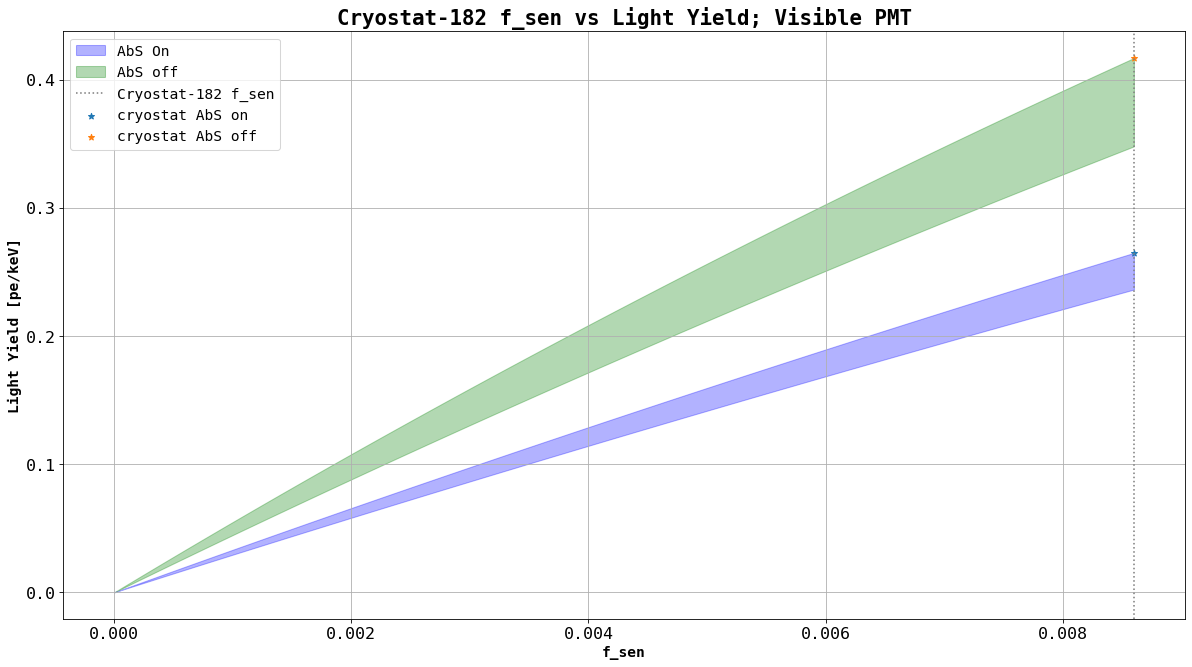

In [ ]:
# %matplotlib qt
# %matplotlib inline

plt.close('Cryostat-182 f_sen vs Light Yield; Visible PMT')
plt.figure('Cryostat-182 f_sen vs Light Yield; Visible PMT')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')

# f_sen_vector = np.arange(0, 0.05, 0.005)
# f_sen_vector = np.arange(0, 1.01, 0.01)
f_sen_vector = np.arange(0, f_sen_cryostat_182_max, 0.0001)

LY_PEN_upper_PMT8 = integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_cryostat_182, Q_vuv= Q_vuv_cryostat_182)
LY_PEN_lower_PMT8 = integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_cryostat_182, Q_vuv= Q_vuv_cryostat_182)
plt.fill_between( f_sen_vector, LY_PEN_lower_PMT8,  LY_PEN_upper_PMT8, color='blue', alpha=0.3, label='AbS On' )

LY_PEN_upper_PMT8_AbS_off = integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47)
LY_PEN_lower_PMT8_AbS_off = integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47)
plt.fill_between( f_sen_vector, LY_PEN_lower_PMT8_AbS_off,  LY_PEN_upper_PMT8_AbS_off, color='green', alpha=0.3, label='AbS off' )

plt.ylabel('Light Yield [pe/keV]' , size =14, weight = 'bold')
plt.xlabel('f_sen', size =14, weight = 'bold')
plt.title('Cryostat-182 f_sen vs Light Yield; Visible PMT')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]

plt.axvline(f_sen_cryostat_182_max, 0, 1, linestyle = 'dotted', color = 'gray', label='Cryostat-182 f_sen')
plt.scatter(f_sen_cryostat_182_max, integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth, f_sen_cryostat_182_max, 
                                  wls_eff= 0.47, Q_vis=Q_vis_cryostat_182, Q_vuv= Q_vuv_cryostat_182), marker='*', label='cryostat AbS on' )
plt.scatter(f_sen_cryostat_182_max, integrate_LY(wavelength_vector, E_PEN_smooth, VIS_PMT_QE, R_VIS_PMT_smooth, R_Wall_PEN_smooth, f_sen_cryostat_182_max, 
                                  wls_eff= 0.47), marker='*', label='cryostat AbS off' )
# plt.legend(loc = 'best')
plt.grid()
plt.legend(loc = 'upper left')

# plt.savefig('f_sen vs LY')

<h3 style = 'color: black;'> VUV PMT </h3>

#### VUV PMT QE

In [ ]:
VUV_PMT_QE =  0.25*np.ones(wavelength_vector.shape[0]) ## this PMT is sensitive in visible and VUV regime

In [ ]:
R_VUV_PMT_smooth = 0.15*np.ones(wavelength_vector.shape[0])

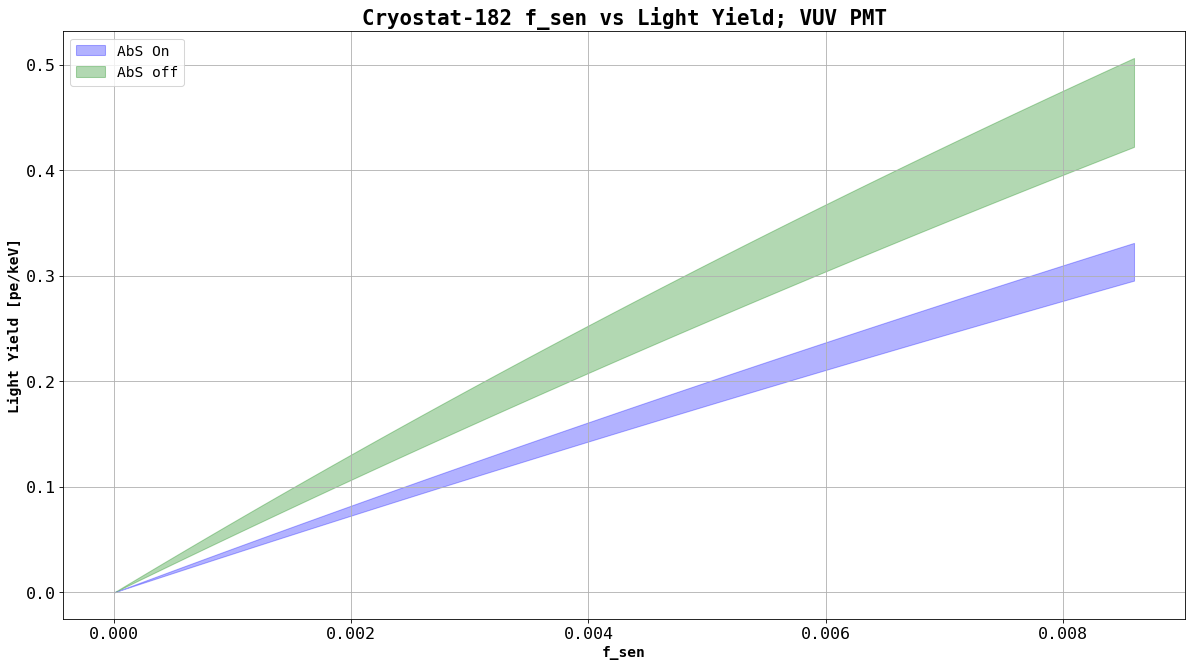

In [ ]:
# %matplotlib qt
# %matplotlib inline

plt.close('Cryostat-182 f_sen vs Light Yield; VUV PMT')
plt.figure('Cryostat-182 f_sen vs Light Yield; VUV PMT')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')
# f_sen_vector = np.arange(0, 0.06, 0.005)
# f_sen_vector = np.arange(0, 1.01, 0.01)
# f_sen_vector = np.arange(0, f_sen_cryostat_182_max, 0.0001)

LY_PEN_upper_PMT3 = integrate_LY(wavelength_vector, E_PEN_smooth, VUV_PMT_QE, R_VUV_PMT_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_cryostat_182, Q_vuv= Q_vuv_cryostat_182)
LY_PEN_lower_PMT3 = integrate_LY(wavelength_vector, E_PEN_smooth, VUV_PMT_QE, R_VUV_PMT_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47, Q_vis=Q_vis_cryostat_182, Q_vuv= Q_vuv_cryostat_182)
plt.fill_between( f_sen_vector, LY_PEN_lower_PMT3,  LY_PEN_upper_PMT3, color='blue', alpha=0.3, label='AbS On' )

LY_PEN_upper_PMT3_AbS_off = integrate_LY(wavelength_vector, E_PEN_smooth, VUV_PMT_QE, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, wls_eff= 0.47)
LY_PEN_lower_PMT3_AbS_off = integrate_LY(wavelength_vector, E_PEN_smooth, VUV_PMT_QE, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, wls_eff= 0.47)
plt.fill_between( f_sen_vector, LY_PEN_lower_PMT3_AbS_off,  LY_PEN_upper_PMT3_AbS_off, color='green', alpha=0.3, label='AbS off' )

plt.ylabel('Light Yield [pe/keV]' , size =14, weight = 'bold')
plt.xlabel('f_sen', size =14, weight = 'bold')
plt.title('Cryostat-182 f_sen vs Light Yield; VUV PMT')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]
plt.legend(loc = 'best')
plt.grid()
plt.legend(loc = 'upper left')
# plt.savefig('f_sen vs LY')

In [ ]:
# plt.close('all')

#### VUV photo electrons

<span style='font-size: 22pt'>
$$
    \text{VUV photo electrons} = SY * f_{sen,\ VUV PMT} * QE_{VUV}
$$
</span>

In [ ]:
SY = 40

In [ ]:
f_sen_PMT3 = ((3*0.0254/2)**2)/hexagon_prism_surface_area

In [ ]:
QE_128 = 0.22

In [ ]:
VUV_pe = SY * f_sen_PMT3 * QE_128

In [ ]:
VUV_pe

0.002970275109011024

<p style='font-size:24pt; font-weight:bold'>
Vis + VUV
</p>

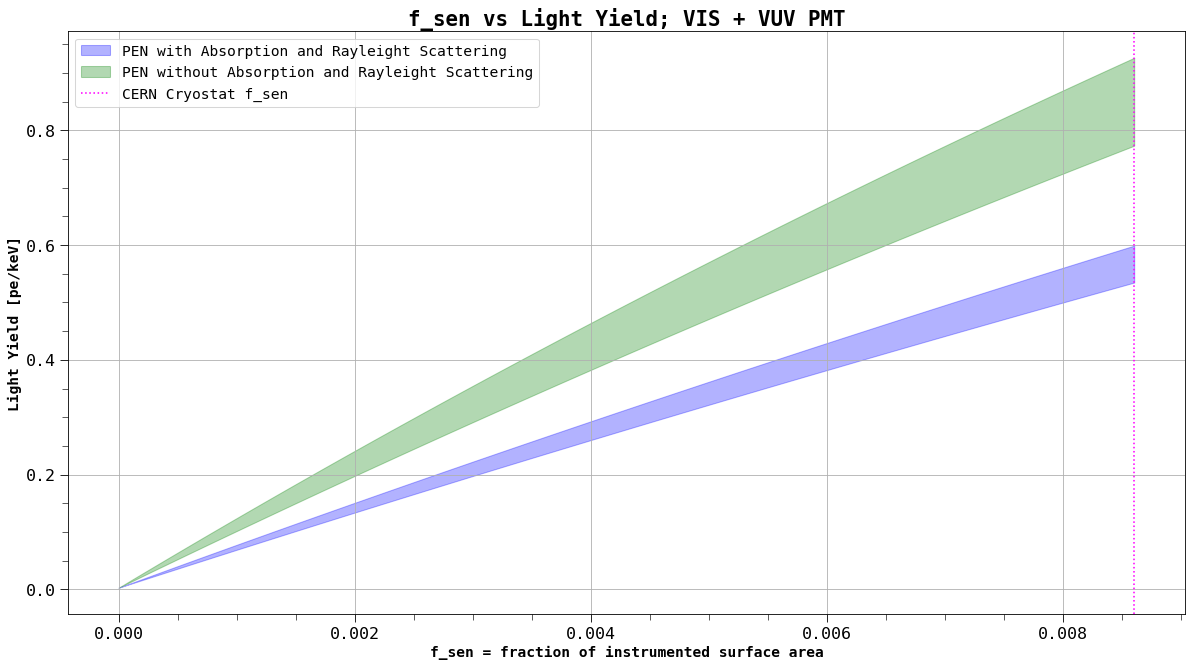

In [ ]:
# %matplotlib qt
# %matplotlib inline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.close('CERN Cryostat f_sen vs Light Yield; VUV+VIS PMT')
fig_vuvis = plt.figure('Cryostat-182 f_sen vs Light Yield; VUV+VIS PMT')
ax_vuvis = plt.axes()
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector,wls_eff = 0.47, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-g')
# plt.plot(f_sen_vector, integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, Q_vis = Q_vis_2PAC, Q_vuv=Q_vuv_2PAC), '-r')
# f_sen_vector = np.arange(0, 0.06, 0.005)
# f_sen_vector = np.arange(0, 1.01, 0.01)
# f_sen_vector = np.arange(0, f_sen_cryostat_182_max, 0.0001)

ax_vuvis.fill_between( f_sen_vector, LY_PEN_lower_PMT8+LY_PEN_lower_PMT3+VUV_pe, 
                 LY_PEN_upper_PMT8+LY_PEN_upper_PMT3+VUV_pe, color='blue', alpha=0.3, label='PEN with Absorption and Rayleight Scattering' )

ax_vuvis.fill_between( f_sen_vector, LY_PEN_lower_PMT8_AbS_off +LY_PEN_lower_PMT3_AbS_off+VUV_pe, 
                 LY_PEN_upper_PMT8_AbS_off+LY_PEN_upper_PMT3_AbS_off+VUV_pe, color='green', alpha=0.3, label='PEN without Absorption and Rayleight Scattering' )

ax_vuvis.set_ylabel('Light Yield [pe/keV]', fontsize=14, weight = 'bold')
ax_vuvis.set_xlabel('f_sen = fraction of instrumented surface area', size =14, weight = 'bold')
ax_vuvis.set_title('f_sen vs Light Yield; VIS + VUV PMT')
# ax_vuvis.plot(f_sen_cryostat_182_max, VUV_pe, label='VUV pe')
### [R_SiPM, R_wall,PDE dependent on wavelength. Absorption and Rayleigh Scattering accounted for]

ax_vuvis.axvline(f_sen_cryostat_182_max, 0, 1, linestyle = 'dotted', color = 'magenta', label='CERN Cryostat f_sen')

ax_vuvis.yaxis.set_minor_locator(AutoMinorLocator())
ax_vuvis.xaxis.set_minor_locator(AutoMinorLocator())
ax_vuvis.tick_params(which='minor', length=6)
ax_vuvis.tick_params(which='major', length=8)


ax_vuvis.legend(loc = 'upper left')
ax_vuvis.grid()
# plt.savefig('CERN_Cryostat_f_sen_vs_LY.pdf')

In [ ]:
f_sen_cryostat_182_max

0.008600906511332131